In [1]:
from qiskit import *
from qiskit.visualization import *
from qiskit.circuit.library import MCMT

from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

import numpy as np
import matplotlib.pyplot as plt
import math

from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

sim = Aer.get_backend('qasm_simulator')

# using tikzplotlib to export plot to latex
import tikzplotlib

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

def save_fig(name, width='10cm', height='10cm'):
    fig = plt.gcf()
    tikzplotlib_fix_ncols(fig)

    tikzplotlib.clean_figure()
    tikzplotlib.save(name + '.tex', axis_width=width, axis_height=height)

In [2]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools import job_monitor

provider = IBMQ.load_account()
device = least_busy(
    provider.backends(
        filters=lambda x: x.configuration().n_qubits >= 7
                          and not x.configuration().simulator                # Not a simulator
                          and x.status().operational == True                 # Operational backend
    )
)

qc_all = []

display(device)

C:\Users\romai\AppData\Local\Temp\ipykernel_29904\546407164.py:5: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


<IBMQBackend('ibm_perth') from IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
# circuit p.34
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)
qc.h(qr[0])
qc.measure(qr, cr)

qc_all.append(qc)

In [4]:
# circuit p.41
qc_c = QuantumCircuit(2)
qc_c.h(0)
qc_c.cx(0, 1)

qc_a00 = QuantumCircuit(2)
qc_a00.id(0)

qc_a01 = QuantumCircuit(2)
qc_a01.x(0)

qc_a10 = QuantumCircuit(2)
qc_a10.z(0)

qc_a11 = QuantumCircuit(2)
qc_a11.z(0)
qc_a11.x(0)

qc_a = [qc_a00, qc_a01, qc_a10, qc_a11]

qc_b = QuantumCircuit(2)
qc_b.cx(0, 1)
qc_b.h(0)
qc_b.measure_all()

qc_out = qc_c.compose(qc_a[2]).compose(qc_b)

qc_all.append(qc_out)

In [5]:
# circuit p.65
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

# Specify variables
N_COUNT = 3  # number of counting qubits
a = 7

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qr = QuantumRegister(N_COUNT + 4)
cr = ClassicalRegister(N_COUNT)
qc = QuantumCircuit(qr, cr)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
              [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))

from qiskit.utils.mitigation import complete_meas_cal, CompleteMeasFitter
meas_calibs1, state_labels1 = complete_meas_cal(qubit_list=[0,1,2,3,4,5,6], circlabel='mcal')

qc_all.append(qc)

In [6]:
# circuit p.80

##### your code goes here ######
q = QuantumRegister(2)
c = ClassicalRegister(3)

qc_T = QuantumCircuit(q,c)

# First step
##1 Initialization
qc_T.h(q[0])
qc_T.x(q[1])
##2 Apply control-U operator as many times as needed to get the least significant phase bit
qc_T.cp(np.pi/4, q[1], q[0])
qc_T.cp(np.pi/4, q[1], q[0])
qc_T.cp(np.pi/4, q[1], q[0])
qc_T.cp(np.pi/4, q[1], q[0])
##3 measure the anscillar qubit in x-basis
qc_T.h(q[0])
qc_T.measure(q[0], c[0])

# Second step
qc_T.barrier()
qc_T.reset(q[0])
##1 Initialization
qc_T.h(q[0])
##2 Apply control-U operator as many times as needed 
qc_T.cp(np.pi/4, q[1], q[0])
qc_T.cp(np.pi/4, q[1], q[0])
##3 phase correction
qc_T.p(-np.pi/2, q[0]).c_if(c[0], 1)
##4 measure the anscillar qubit in x-basis
qc_T.h(q[0])
qc_T.measure(q[0], c[1])

# Third step
qc_T.barrier()
qc_T.reset(q[0])
##1 Initialization
qc_T.h(q[0])
##2 Apply control-U operator as many times as needed to get the least significant phase bit
qc_T.cp(np.pi/4, q[1], q[0])
##3 phase correction
qc_T.p(-np.pi/2, q[0]).c_if(c[1], 1)
qc_T.p(-np.pi/4, q[0]).c_if(c[0], 1)
##4 measure the anscillar qubit in x-basis
qc_T.h(q[0])
qc_T.measure(q[0], c[2])

# qc_all.append(qc_T)

In [7]:
# erreur p.84

# circuit for the state Tri1
Tri1 = QuantumCircuit(2)
# your code goes here
Tri1.h(0)
Tri1.cx(0,1)

# circuit for the state Tri2
Tri2 = QuantumCircuit(2)
# your code goes here
Tri2.x(0)
Tri2.h(0)
Tri2.cx(0,1)

# circuit for the state Tri3
Tri3 = QuantumCircuit(2)
# your code goes here
Tri3.x(1)
Tri3.h(0)
Tri3.cx(0,1)

# circuit for the state Sing
Sing = QuantumCircuit(2)
# your code goes here
Sing.x(1)
Sing.h(0)
Sing.z(0)
Sing.z(1)
Sing.cx(0,1)

# <ZZ> 
measure_ZZ = QuantumCircuit(2)
measure_ZZ.measure_all()

# <XX>
measure_XX = QuantumCircuit(2)
# your code goes here
measure_XX.h([0,1])
measure_XX.measure_all()



# <YY>
measure_YY = QuantumCircuit(2)
# your code goes here
measure_YY.sdg([0,1])
measure_YY.h([0,1])
measure_YY.measure_all()

qc_mod = [state_init.compose(measure_circuit) for state_init in [Tri1,Tri2,Tri3,Sing]
          for measure_circuit in [measure_XX, measure_YY, measure_ZZ] ]

meas_calibs2, state_labels2 = complete_meas_cal(qr=2, circlabel='mcal')

for i in qc_mod:
    qc_all.append(i)

In [8]:
qc_all

In [9]:
shots = 8192

# Submit a job.
job = execute(qc_all, backend=device, optimization_level=3, shots=shots)
job_monitor(job)

Job Status: job has successfully run


{'0': 4159, '1': 4033}


C:\Users\romai\AppData\Roaming\Python\Python310\site-packages\tikzplotlib\_cleanfigure.py:200: UserWarning: Cleaning Bar Container (bar plot) is not supported yet.
  warnings.warn("Cleaning Bar Container (bar plot) is not supported yet.")


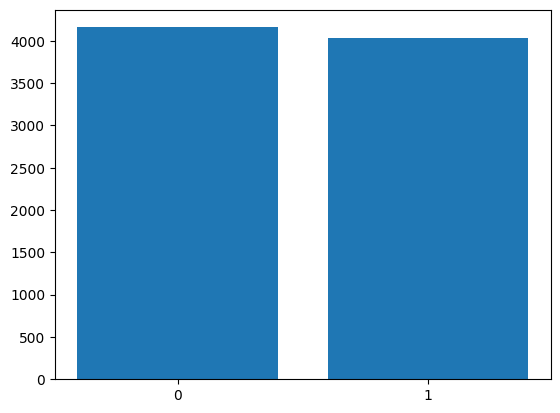

In [10]:
# 34
count34 = job.result().get_counts(0)
print(count34)
plt.bar(count34.keys(), count34.values())
save_fig('real-mes-supp')

{'0': 4159, '1': 4033}


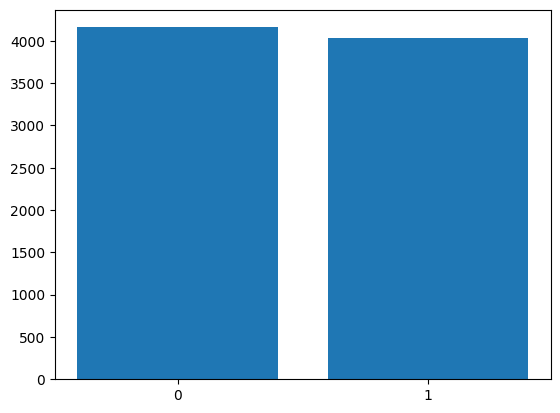

In [11]:
# 41
count41 = job.result().get_counts(1)
print(count41)
plt.bar(count41.keys(), count41.values())
save_fig('sup-cod-his')

In [12]:
jobcal1 = execute(meas_calibs1, backend=device)
job_monitor(jobcal1)

Job Status: job has successfully run


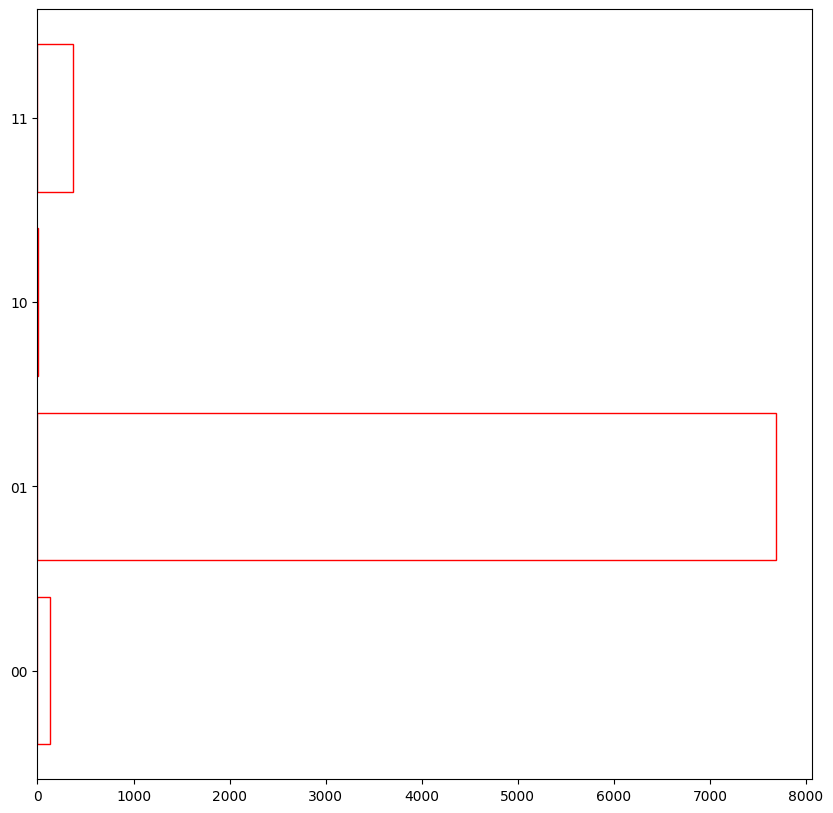

In [16]:
# 65

count65 = job.result().get_counts(2)
# meas_cal_65 = jobcal1.result()
# 
# meas_fitter = CompleteMeasFitter(meas_cal_65, state_labels1, circlabel='mcal')
# meas_filter = meas_fitter.filter
# 
# mitigated_results = meas_filter.apply(job.result())
# mitigated_counts = mitigated_results.get_counts()

plt.figure(figsize=(10,10))
plt.barh(list(count65.keys()), count65.values(), edgecolor='red', fill=False)
# plt.barh(list(mitigated_counts.keys()), mitigated_counts.values(), edgecolor='blue', fill=False)
save_fig('shor_plot_mitigated')

In [14]:
# 80

# count80 = job.result().get_counts(2)
# 
# n=3
# key_new = [str(int(key,2)/2**n) for key in list(count80.keys())]
# count1 = dict(zip(key_new, count80.values()))
# 
# fig, ax = plt.subplots(1,2)
# plot_histogram(count80, ax=ax[0])
# plot_histogram(count1, ax=ax[1])
# plt.tight_layout()
# 
# save_fig('ipe_real')

In [ ]:
jobcal2 = execute(meas_calibs2, backend=device)
job_monitor(jobcal2)

In [17]:
# 84

shots = 2**16 # number of samples used for statistics

A = 1.47e-6 #unit of A is eV
E_sim = []
for state_init in [Tri1,Tri2,Tri3,Sing]:
    Energy_meas = []
    for measure_circuit in [measure_XX, measure_YY, measure_ZZ]:

        # run the circuit with the selected measurement and get the number of samples that output each bit value
        qc = state_init.compose(measure_circuit)
        qc_trans = transpile(qc, sim)
        counts = sim.run(qc_trans, shots=shots).result().get_counts()

        # calculate the probabilities for each computational basis
        probs = {}
        for output in ['00','01', '10', '11']:
            if output in counts:
                probs[output] = counts[output]/shots
            else:
                probs[output] = 0

        Energy_meas.append( probs['00'] - probs['01'] - probs['10'] + probs['11'] )

    E_sim.append(A * np.sum(np.array(Energy_meas)))

results = job.result()

def Energy(results, shots):
    """Compute the energy levels of the hydrogen ground state.
    
    Parameters:
        results (obj): results, results from executing the circuits for measuring a hamiltonian.
        shots (int): shots, number of shots used for the circuit execution.
        
    Returns:
        Energy (list): energy values of the four different hydrogen ground states
    """
    E = []
    A = 1.47e-6

    for ind_state in range(4):
        Energy_meas = []
        for ind_comp in range(3):
            counts = results.get_counts(3 + ind_state*3+ind_comp)

            # calculate the probabilities for each computational basis
            probs = {}
            for output in ['00','01', '10', '11']:
                if output in counts:
                    probs[output] = counts[output]/shots
                else:
                    probs[output] = 0

            Energy_meas.append( probs['00'] - probs['01'] - probs['10'] + probs['11'] )

        E.append(A * np.sum(np.array(Energy_meas)))

    return E

E = Energy(results, shots)

print('Energy expection value of the state Tri1 : {:.3e} eV'.format(E[0]))
print('Energy expection value of the state Tri2 : {:.3e} eV'.format(E[1]))
print('Energy expection value of the state Tri3 : {:.3e} eV'.format(E[2]))
print('Energy expection value of the state Sing : {:.3e} eV'.format(E[3]))

# cal_results = jobcal2.result()
# meas_fitter = CompleteMeasFitter(cal_results, state_labels2, circlabel='mcal')
# meas_filter = meas_fitter.filter
# 
# results_new = meas_filter.apply(results)
# 
# E_new = Energy(results_new, shots)
# 
# print('Energy expection value of the state Tri1 : {:.3e} eV'.format(E_new[0]))
# print('Energy expection value of the state Tri2 : {:.3e} eV'.format(E_new[1]))
# print('Energy expection value of the state Tri3 : {:.3e} eV'.format(E_new[2]))
# print('Energy expection value of the state Sing : {:.3e} eV'.format(E_new[3]))

# Energy_exact, Energy_exp_orig, Energy_exp_new = np.array(E_sim), np.array(E), np.array(E_new)
# 
# Err_rel_orig = np.round(np.abs(Energy_exact - Energy_exp_orig)/Energy_exact, 4)
# 
# Err_rel_new = np.round(np.abs(Energy_exact - Energy_exp_new)/Energy_exact, 4)
# 
# np.set_printoptions(precision=3)
# 
# print('The relative errors of the energy values for four bell basis\
#  without measurement error mitigation : {}'.format(Err_rel_orig))
# 
# np.set_printoptions(precision=3)
# 
# print('The relative errors of the energy values for four bell basis\
#  with measurement error mitigation : {}'.format(Err_rel_new))

Energy expection value of the state Tri1 : 1.706e-07 eV
Energy expection value of the state Tri2 : 1.495e-07 eV
Energy expection value of the state Tri3 : 1.523e-07 eV
Energy expection value of the state Sing : -4.852e-07 eV
